In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()

LOADING THE DATASET

In [2]:
ckd= pd.read_csv('new_model.csv')

In [3]:
ckd.isnull().sum()

bp                0
sg                0
al                0
su                0
rbc               0
bu                0
sc                0
sod               0
pot               0
hemo              0
wc                0
rc                0
htn               0
classification    0
dtype: int64

In [4]:
ckd['classification'].value_counts()

classification
1    250
0    150
Name: count, dtype: int64

In [5]:
#1 -> Defective kidney
#0 -> Healthy kidney

CHECKING FOR IMBALANCES

Axes(0.125,0.11;0.775x0.77)


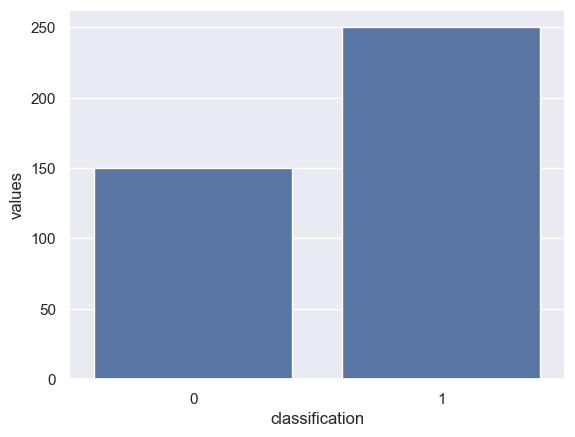

In [6]:
temp=ckd["classification"].value_counts()
temp_ckd=pd.DataFrame({"classification": temp.index, 'values': temp.values})
print(sns.barplot(x='classification',y="values", data=temp_ckd))

FIXING DATATYPE ERRORS

In [7]:
ckd.dtypes

bp                  int64
sg                float64
al                  int64
su                  int64
rbc                 int64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
wc                  int64
rc                float64
htn               float64
classification      int64
dtype: object

In [8]:
ckd.select_dtypes(exclude=["object"]).columns

Index(['bp', 'sg', 'al', 'su', 'rbc', 'bu', 'sc', 'sod', 'pot', 'hemo', 'wc',
       'rc', 'htn', 'classification'],
      dtype='object')

CHANGING ALL INTEGER VALUES TO FLOAT

In [9]:
for i in ckd.select_dtypes(exclude=["object"]).columns:
  ckd[i]=ckd[i].apply(lambda x: float(x))
  
  

In [10]:
ckd.dtypes

bp                float64
sg                float64
al                float64
su                float64
rbc               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
wc                float64
rc                float64
htn               float64
classification    float64
dtype: object

VISUALIZATION USING SEABORN

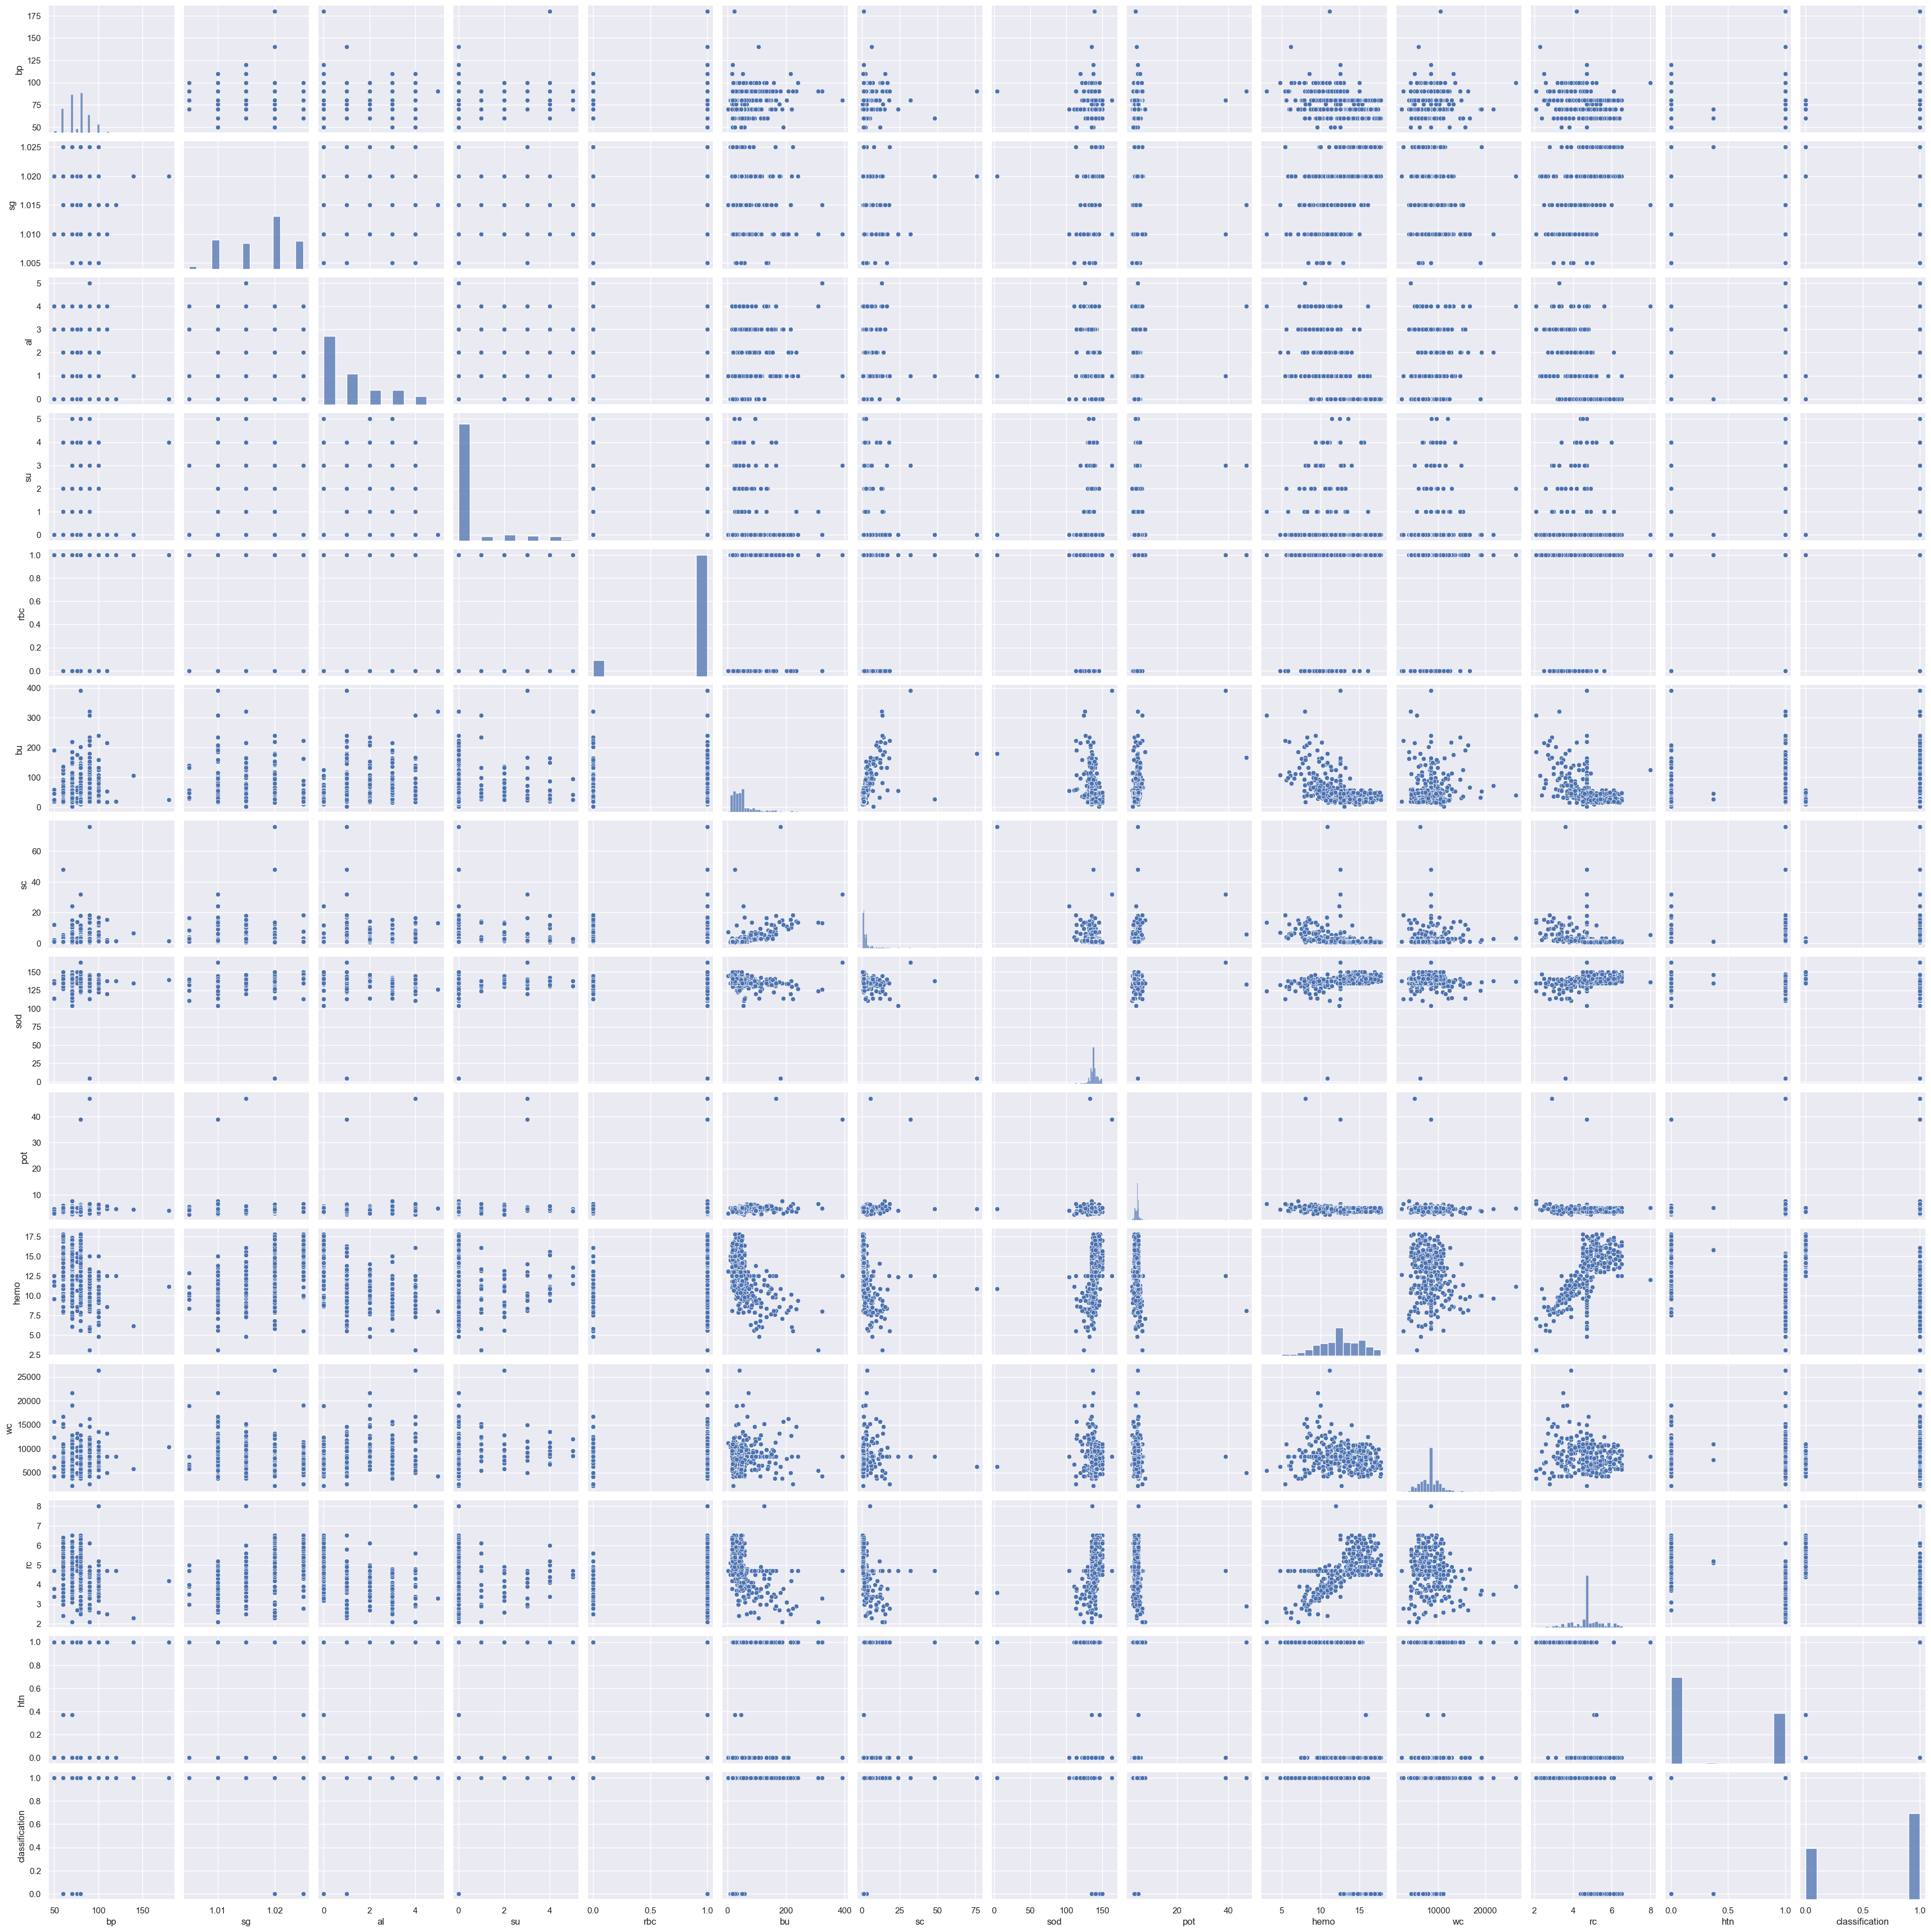

In [11]:
sns.pairplot(ckd)

FINDING THE DISRIBUTION

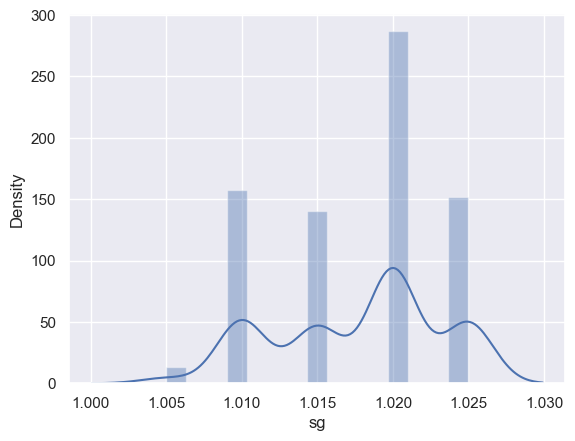

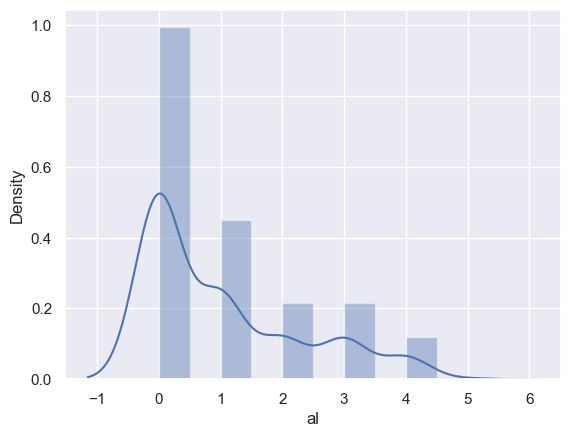

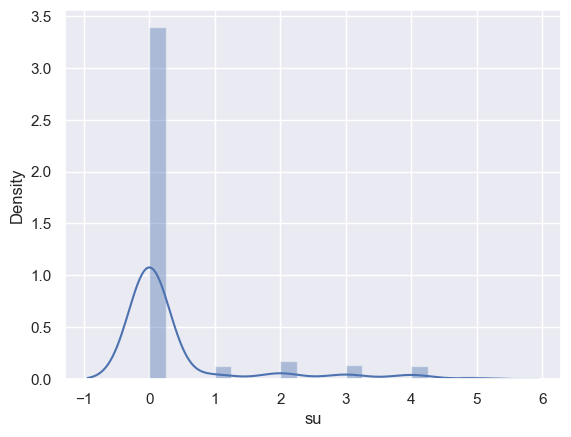

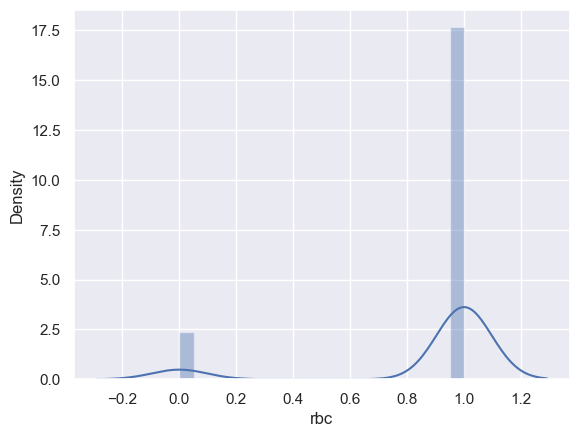

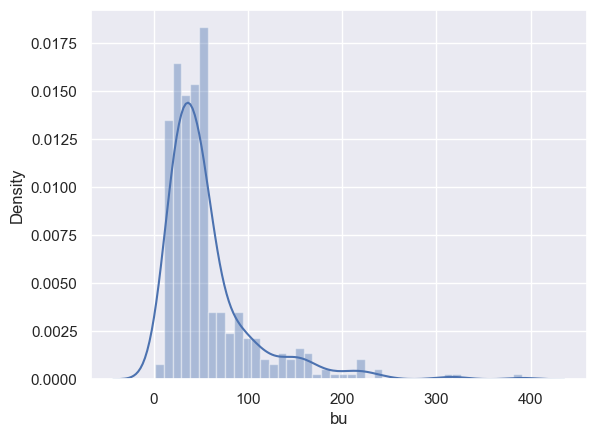

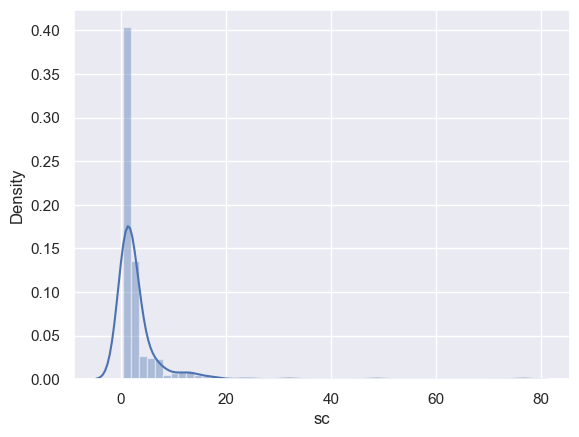

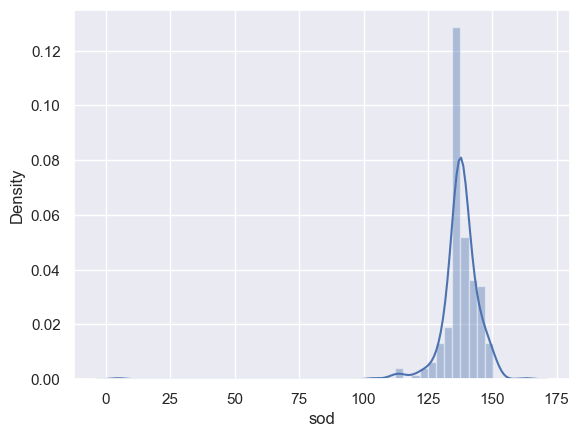

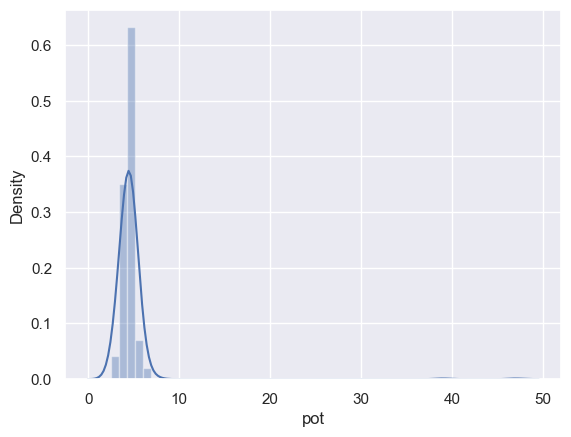

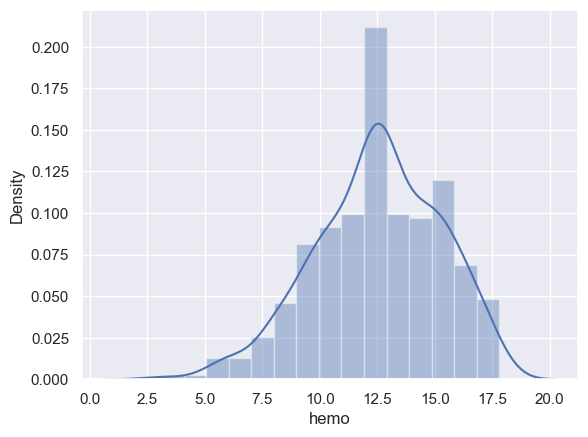

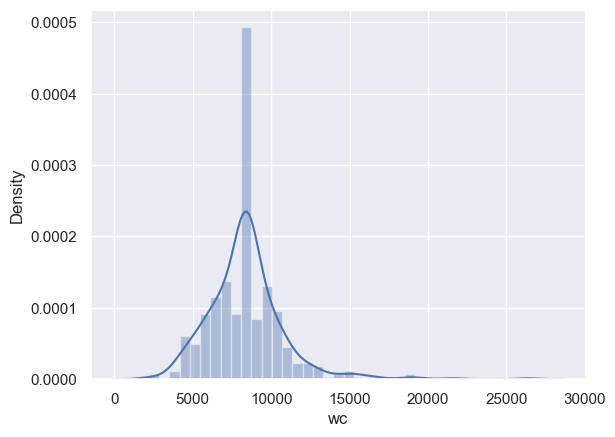

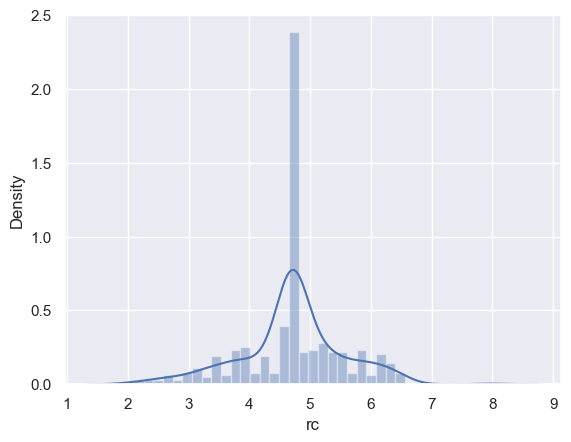

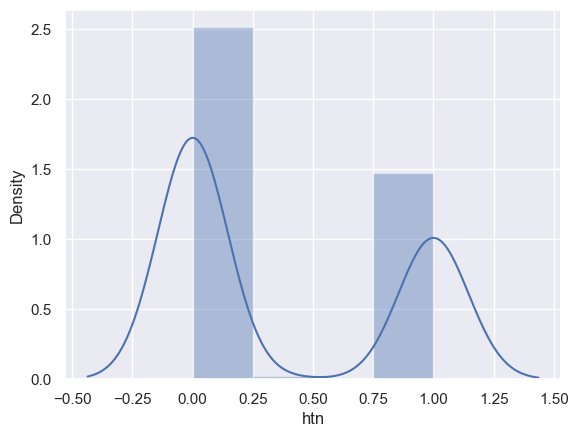

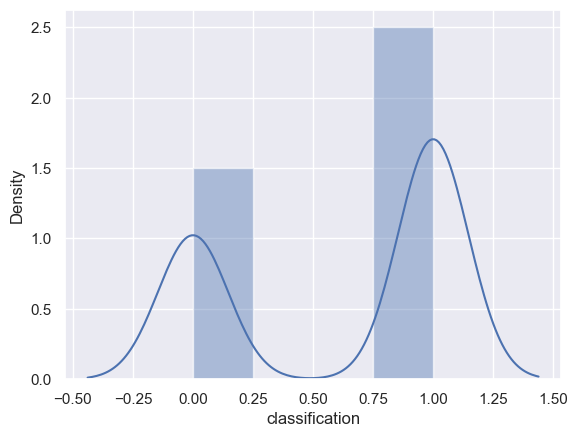

In [12]:
def distplots(col):
  sns.distplot(ckd[col])
  plt.show()

for i in list(ckd.select_dtypes(exclude=["object"]).columns)[1:]:
    distplots(i)

REMOVING OUTLIERS

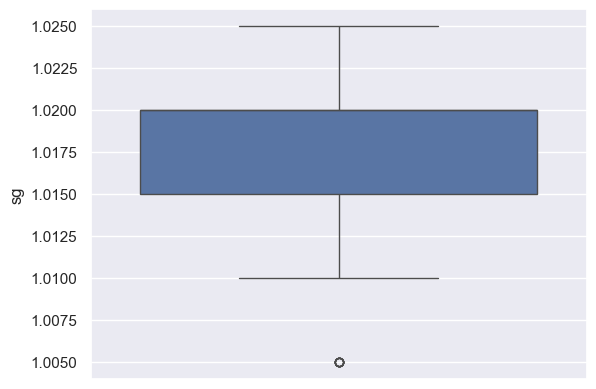

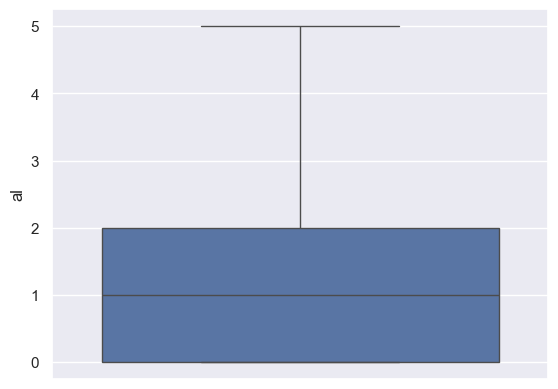

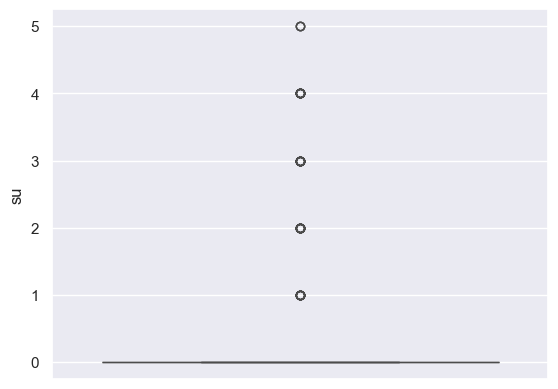

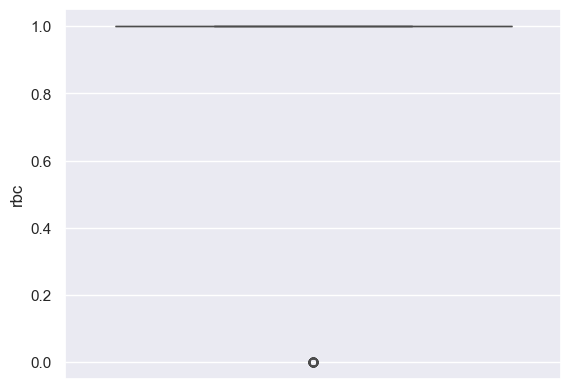

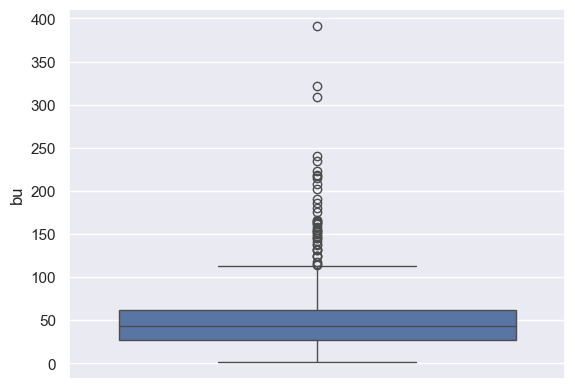

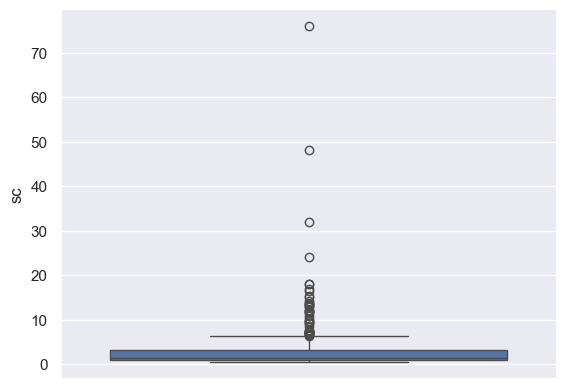

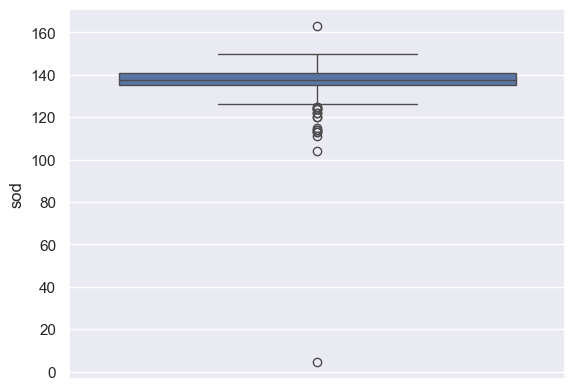

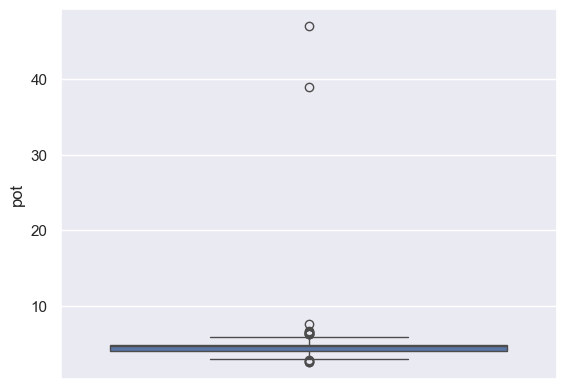

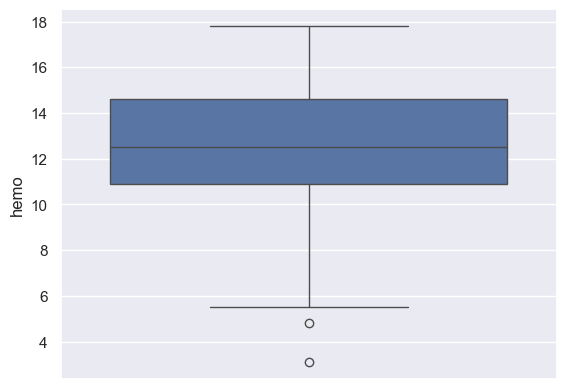

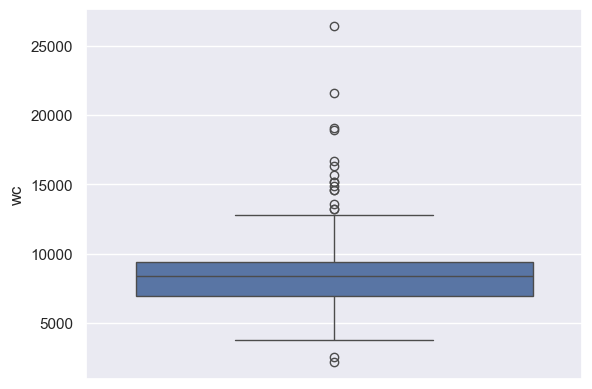

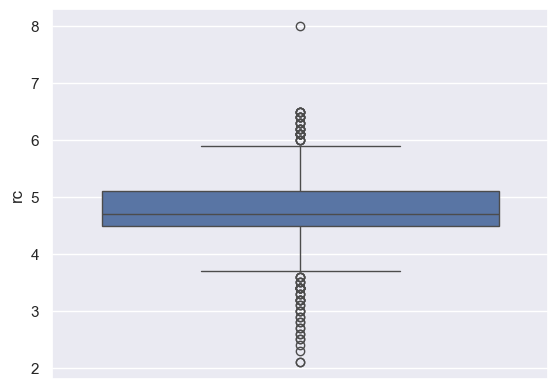

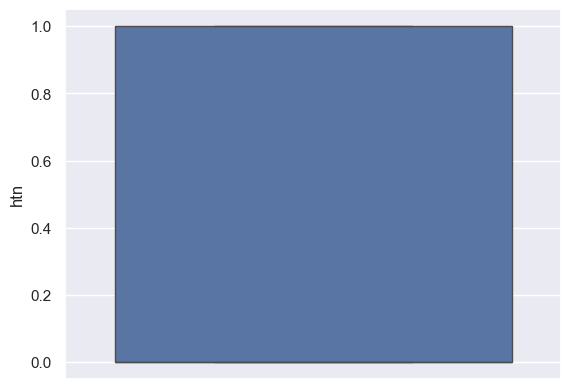

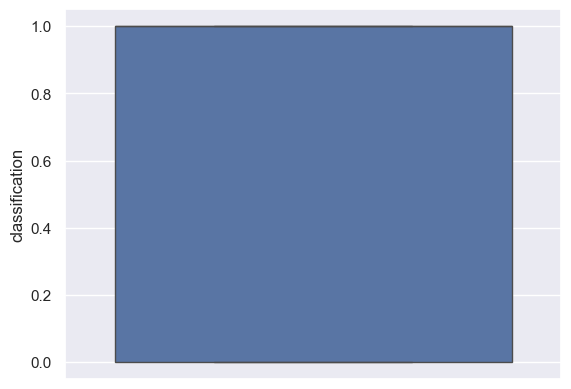

In [13]:
def boxplots(col):
  sns.boxplot(ckd[col])
  plt.show()

for i in list(ckd.select_dtypes(exclude=["object"]).columns)[1:]:
  boxplots(i)

FINDING THE CORRELATION

<Axes: >

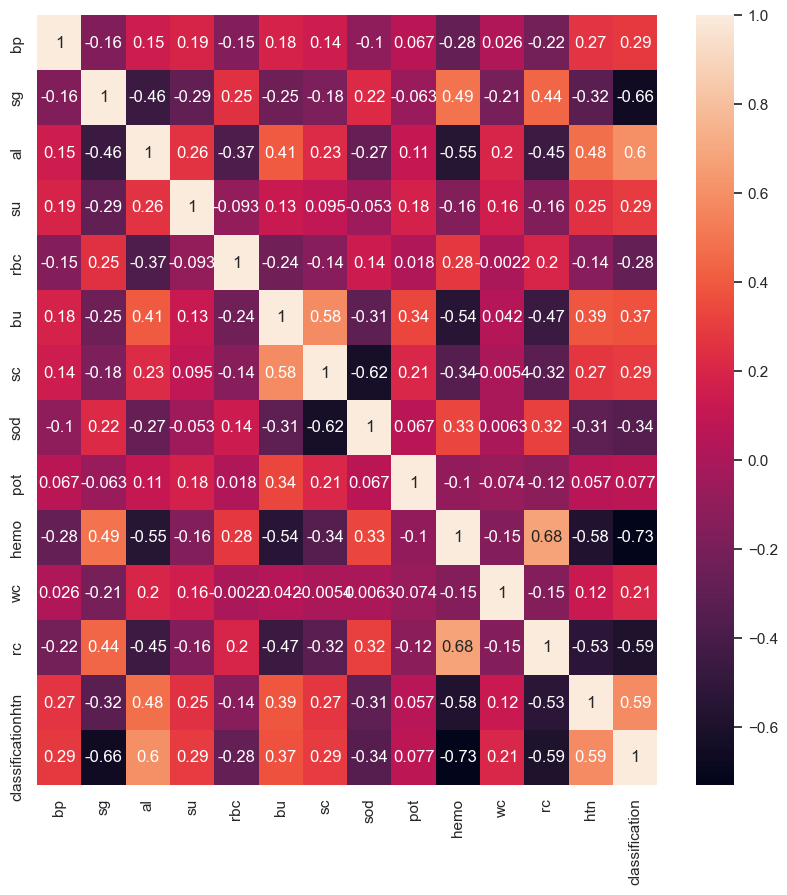

In [14]:
plt.figure(figsize=(10,10))
corr=ckd.corr()
sns.heatmap(corr, annot=True)

FEATURE ENGINEERING

In [15]:
x=ckd.drop(["classification"],axis=1)
y=ckd["classification"]

DETECTING LABEL IMBALANCE

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print(Counter(y))

Counter({1.0: 250, 0.0: 150})


BALANCING THE LABELS

In [17]:


ros= RandomOverSampler()

x_ros, y_ros = ros.fit_resample(x,y)
print(Counter(y_ros))

Counter({1.0: 250, 0.0: 250})


NORMALIZING THE DATA

In [18]:
#Initialize a MinMaxScalar and scale the features to between -1 and 1 to normalize them.
#MinMaxScaler transforms features by scaling them to a given range.
#The fit_transform() method fits to the data and then transforms it. We don't need to scales the labels.
#Scale the features to between -1 and 1

#Scaling is important in the algorithms such as support vector machines(SVM) and k-nearest neighbors(KNN) where distance
#between the data points is important.

scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(x_ros)
y=y_ros

PRINCIPAL COMPONENT ANALYSIS(PCA)

In [19]:
#used for dimensionality reduction and data visualization.
#The code below has .95 for the number of components parameter.
#It means that scikit-learn choose the minimum number of principal components such that 95% of the variance is retained

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA

pca = PCA(.95)
x_PCA=pca.fit_transform(x)

print(x.shape)
print(x_PCA.shape)

#we need 18 columns to keep a variance of 95%

(500, 13)
(500, 8)


In [20]:
#With PCA

#Split the dataset into training and testing sets keeping 20% of the data for testing.
#Split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_PCA,y, test_size=0.2, random_state=7)

MODEL DEVELOPMENT

In [21]:
import keras
#A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold

defining the model

In [22]:
def model():
  
  classifier = Sequential()
  classifier.add(Dense(15, input_shape=(x_train.shape[1],),activation='relu'))
  classifier.add(Dropout(0.2))
  classifier.add(Dense(15,activation='relu'))
  classifier.add(Dropout(0.4))
  classifier.add(Dense(1, activation = 'sigmoid'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics =['accuracy'])

  return classifier

In [23]:
x_train.shape[1]

8

In [24]:
model = model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391 (1.53 KB)

 Trainable params: 391 (1.53 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history =model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs =10,batch_size=15, verbose= 1)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6863 - loss: 0.6478 - val_accuracy: 0.9500 - val_loss: 0.5926
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8408 - loss: 0.5768 - val_accuracy: 0.9500 - val_loss: 0.5239
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8635 - loss: 0.5214 - val_accuracy: 0.9600 - val_loss: 0.4510
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8702 - loss: 0.4454 - val_accuracy: 0.9600 - val_loss: 0.3777
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9436 - loss: 0.3841 - val_accuracy: 0.9700 - val_loss: 0.3050
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9336 - loss: 0.3272 - val_accuracy: 0.9700 - val_loss: 0.2427
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9254 - loss: 0.2857 - val_accuracy: 0.9700 - val_loss: 0.1912
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - loss: 0.2172 - val_accuracy: 0.9700 - val_loss

MODEL LOSS AND ACCURACY VALUES

In [26]:
loss,accuracy=model.evaluate(x_test,y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.1002 
Loss: 0.10604405403137207
Accuracy: 0.9700000286102295


In [27]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_recall_fscore_support, f1_score, confusion_matrix

#function to plot the roc_curve
def plot_auc(t_y,p_y):
  fpr,tpr, thresholds = roc_curve(t_y, p_y,pos_label=1)
  fig, c_ax = plt.subplots(1,1, figsize = (8,6))
  c_ax.plot(fpr,tpr,label = '%s [AUC:%0.2f]' % ('classification', auc(fpr,tpr)))
  c_ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')

  #function to plot the precision_recall_curve
def plot_precision_recall_curve_helper(t_y,p_y):
    fig, c_ax= plt.subplots(1,1, figsize =(8,6))
    precision,recall,thresholds =precision_recall_curve(t_y,p_y,pos_label=1)
    aps=average_precision_score(t_y,p_y)
    c_ax.plot(recall,precision,label='%s (AP Score:%0.2f)' % ('classification',aps))
    c_ax.plot(recall,precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
        #function to plot the history
def plot_history(history):
      f= plt.figure()
      f.set_figwidth(15)


      f.add_subplot(1, 2, 1)
      plt.plot(history.history['val_loss'],label='val loss')
      plt.plot(history.history['loss'],label='train loss')
      plt.legend()
      plt.title("MODEL LOSS")

      f.add_subplot(1, 2, 2)
      plt.plot(history.history['val_accuracy'],label='val accuracy')
      plt.plot(history.history['accuracy'],label='train accuracy')
      plt.legend()
      plt.title("MODEL ACCURACY")

      plt.show()

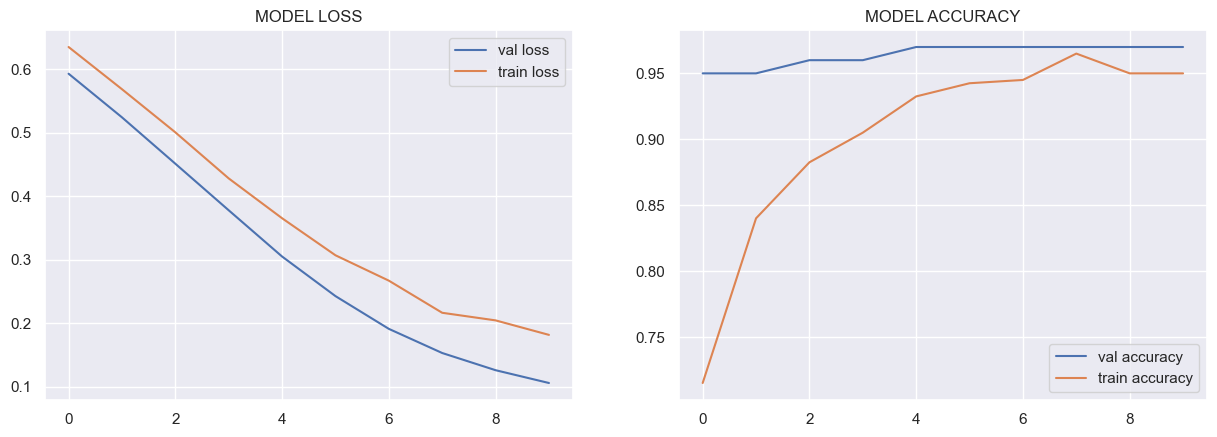

In [28]:
hist=plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


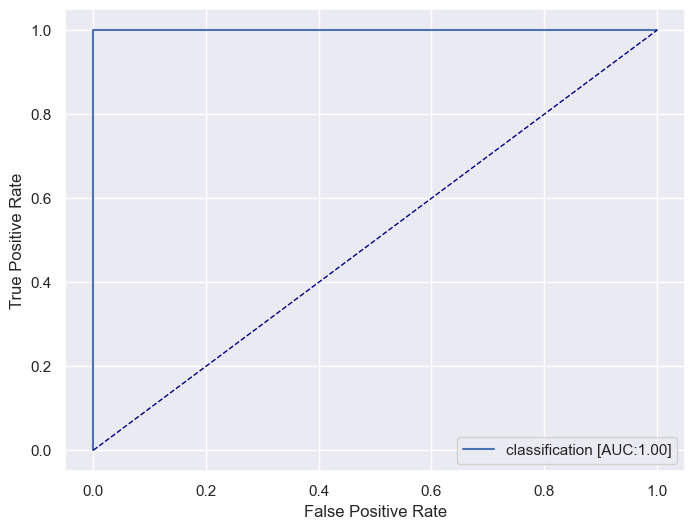

In [29]:
plot_auc(y_test, model.predict(x_test, verbose =True))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


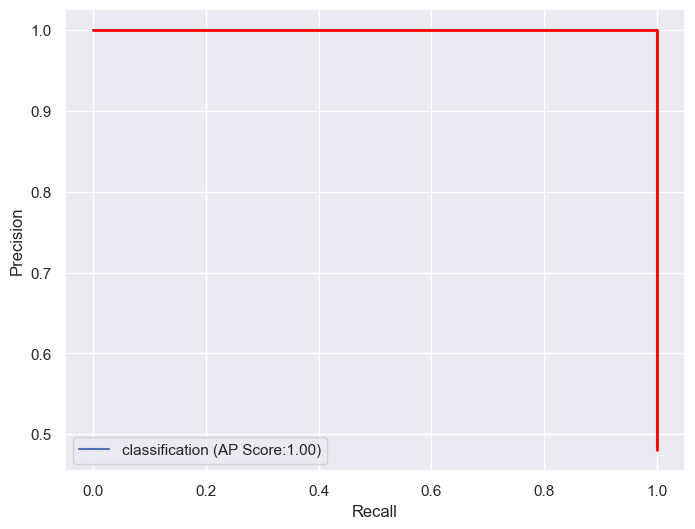

In [30]:
plot_precision_recall_curve_helper(y_test,model.predict(x_test,verbose =True))

MODEL OPTIMIZATION

In [31]:
#Find the threshold that optimize your model's performance,
#and use that threshold to make binary classification.

def calc_f1(prec,recall):
  return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds=precision_recall_curve(y_test,model.predict(x_test,verbose =True))
f1score =[calc_f1(precision[i], recall[i]) for i in range(len(thresholds))]
idx=np.argmax(f1score)
threshold=thresholds[idx]
loss,accuracy=model.evaluate(x_test,y_test)
print('----------------------------------------------')
print('Precision: '+ str(precision[idx]))
print("Accuracy:", accuracy)
print("Loss:", loss)
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: '+ str(f1score[idx]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.1002 
----------------------------------------------
Precision: 1.0
Accuracy: 0.9700000286102295
Loss: 0.10604405403137207
Recall: 1.0
Threshold: 0.27282342
F1 Score: 1.0


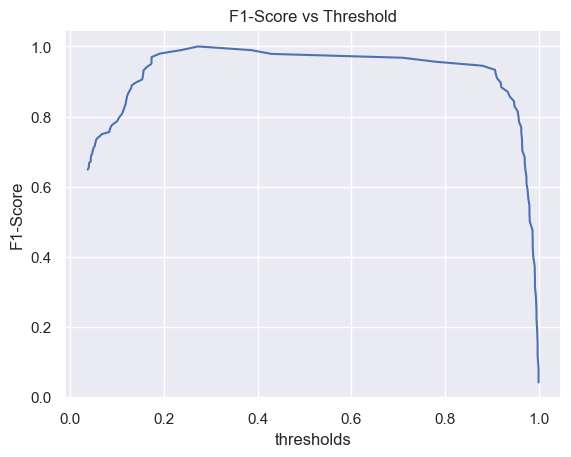

In [32]:
#the threshold or cut_off represents in a binary classification the probability
#that the prediction is true.

plt.figure()
plt.plot(thresholds,f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("thresholds")
plt.ylabel("F1-Score")
plt.show()

PREDICTION AND INTERPRETATON

In [68]:
# User Input Functionality
def get_user_input():
    user_data = {}
    for column in ckd.columns[:-1]:  # Exclude the 'classification' column
        user_data[column] = float(input(f"Enter value for {column}: "))
    return user_data

def preprocess_input(user_data):
    user_df = pd.DataFrame(user_data, index=[0])
    user_scaled = scaler.transform(user_df)
    user_pca = pca.transform(user_scaled)
    return user_pca

def interpret_prediction(prediction, threshold=0.5):
    if prediction >= threshold:
        return "The patient is likely suffering from CKD"
    else:
        return "Healthy kidney"

# Get user input and make prediction
user_data = get_user_input()
user_input_processed = preprocess_input(user_data)
prediction = model.predict(user_input_processed)[0][0]
result = interpret_prediction(prediction)

print(f"Model Prediction: {result} \n")

#DIET SUGGESTION BASED ON PREDICTION
def diet_plan(result):
    if result == "The patient is likely suffering from CKD" :
        diet_suggestion = """
        To improve your condition, do the following:
        
        - Drink adequate water, but not excessively.
        - Minimize intake of fizzy drinks.
        - Avoid alcohol
        - Limit protein intake to reduce the workload on kidneys.
        - Choose high-quality protein sources like fish, poultry, and eggs.
        - Reduce sodium intake to control blood pressure.
        - Limit foods high in phosphorus such as dairy, nuts, seeds.
        - Limit potassium-rich foods such as bananas, oranges, potatoes.
        - Consult with a dietitian for a personalized plan.
        """
        
    if result == "Healthy kidney":
        diet_suggestion = """
        Diet Suggestions for Healthy Kidneys:
        
        - Eat plenty of fruits and vegetables.
        - Minimize intake of fizzy drinks.
        - Minimize alcohol intake
        - Maintain a balanced diet with a variety of foods.
        - Ensure adequate hydration by drinking enough water.
        - Include whole grains and lean proteins.
        - Limit intake of processed foods and high-sodium snacks.
        - Avoid excessive amounts of sugar and saturated fats.
        """
    return diet_suggestion

import time
import sys

def animate_text(text):
    for char in text:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(0.03)  # Adjusting speed of animation

diet_suggestion = diet_plan(result)
 # Change text color to green
sys.stdout.write("\033[92m")
animate_text("Generating diet suggestions per the prediction...\n")
# Change text color to white
sys.stdout.write("\033[0m")
animate_text(diet_suggestion)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Model Prediction: Healthy kidney 

Generating diet suggestions per the prediction...

        Diet Suggestions for Healthy Kidneys:
        
        - Eat plenty of fruits and vegetables.
        - Minimize intake of fizzy drinks.
        - Minimize alcohol intake
        - Maintain a balanced diet with a variety of foods.
        - Ensure adequate hydration by drinking enough water.
        - Include whole grains and lean proteins.
        - Limit intake of processed foods and high-sodium snacks.
        - Avoid excessive amounts of sugar and saturated fats.
        